In [29]:
import tensorflow as tf
import pandas as pd
import math
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

SHUFFLE_BUFFER = 500
BATCH_SIZE = 36
EPOCHS = 50

In [30]:
data = pd.read_csv('data/prepared_data.csv')

TRAINING_SIZE = math.floor(0.5*len(data))
TEST_SIZE = math.floor(0.3*len(data))
EVALUATION_SIZE = math.floor(0.2*len(data))

indices = (TRAINING_SIZE, TRAINING_SIZE+TEST_SIZE, TRAINING_SIZE+TEST_SIZE+EVALUATION_SIZE)
inputs = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']
outputs = ['class_GALAXY','class_QSO','class_STAR']

training = data[0:indices[0]]
test = data[indices[0]:indices[1]]
evaluation = data[indices[1]:indices[2]]
def update_professor():
	return {
		"training": {
			"questions": training[inputs],
			"answers": training[outputs]
		},
		"test": {
			"questions": test[inputs],
			"answers": test[outputs]
		},
		"evaluation": {
			"questions": evaluation[inputs],
			"answers": evaluation[outputs]
		}
	}
professor = update_professor()

# Curriculum Learning Method

# Inception Network

This is the network trained on the entire dataset

In [31]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(data[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']])

inception_model = keras.models.load_model(filepath='neural-network.tf')

inception_model.compile(
	optimizer='sgd',
	loss=keras.losses.BinaryCrossentropy(),
	metrics=['accuracy']
)

history = inception_model.fit(professor['training']['questions'], professor['training']['answers'], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
139/139 [==============================] - 1s 2ms/step - loss: 0.3809 - accuracy: 0.9586 - val_loss: 0.3839 - val_accuracy: 0.9580
Epoch 2/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.9594 - val_loss: 0.3832 - val_accuracy: 0.9583
Epoch 3/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3799 - accuracy: 0.9592 - val_loss: 0.3828 - val_accuracy: 0.9583
Epoch 4/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3794 - accuracy: 0.9598 - val_loss: 0.3826 - val_accuracy: 0.9597
Epoch 5/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.9602 - val_loss: 0.3819 - val_accuracy: 0.9583
Epoch 6/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3786 - accuracy: 0.9594 - val_loss: 0.3818 - val_accuracy: 0.9600
Epoch 7/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3782 - accuracy: 0.9598 - val_loss: 0.3812 - val_accuracy: 0.9580
Epoch 

# Physically Verify that Model is Correct

In [32]:
inception_model.evaluate(professor["evaluation"]["questions"], professor['evaluation']['answers'])

63/63 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.9635


[0.3693690001964569, 0.9635000228881836]

In [33]:
sample = evaluation.sample(5)
print(sample[outputs])
inception_model.__call__(sample[inputs])

      class_GALAXY  class_QSO  class_STAR
9167           0.1        0.1         0.9
8020           0.9        0.1         0.1
9240           0.9        0.1         0.1
8199           0.9        0.1         0.1
9183           0.9        0.1         0.1


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.1541931 , 0.12224779, 0.846355  ],
       [0.9025228 , 0.09606981, 0.09417978],
       [0.8104628 , 0.10096303, 0.14602742],
       [0.90562433, 0.09364176, 0.09055525],
       [0.67965144, 0.09966871, 0.3112774 ]], dtype=float32)>

Text(0.5, 1.0, 'Graph to show Training vs Validation Accuracy')

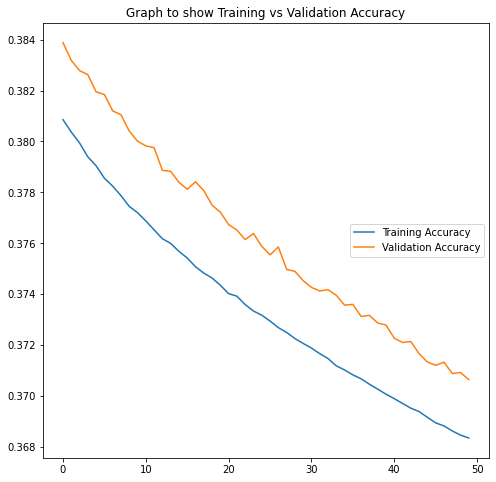

In [34]:
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["loss"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_loss"], label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Graph to show Training vs Validation Accuracy')

Text(0.5, 1.0, 'Graph to show Training vs Validation Loss')

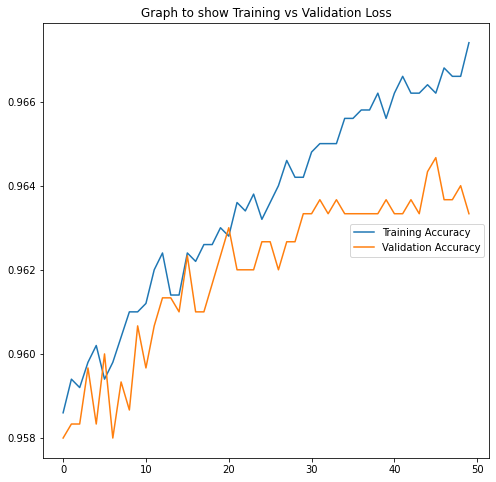

In [35]:
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Graph to show Training vs Validation Loss')

# Curriculum Learning Method

### Score Data -  Self-taught Scoring Function

In [36]:
# curriculum_learning_method(g, f, X:pd.DataFrame):
from sys import stdout
print('[clm]: scoring Xi')
preds = inception_model.predict(training[inputs])
def calc_score(x, output):
	x = list(x)
	output = list(output)
	correct = x.index(max(x)) == output.index(max(output))
	# print({"X": x, "output":output, "corr":correct})
	return max(x) + 1 if correct else -1

score = pd.Series([calc_score(x, training.loc[i, outputs]) for i, x in enumerate(preds)])
temp = pd.DataFrame({**{x:training[x] for x in training}, "score": score, "preds": list(preds) })
temp.head()

[clm]: scoring Xi


,Unnamed: 0,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR,score,preds
0,0,0.167450,-0.584893,1.031435,-0.348542,-0.837238,-0.946010,-0.995292,-0.369713,0.1,0.1,0.9,1.761255,"[0.21138066, 0.058980107, 0.76125526]"
1,1,0.168853,-0.583085,0.052428,-0.166524,-0.154148,-0.082640,-0.026042,-0.369831,0.1,0.1,0.9,1.890938,"[0.10954416, 0.08625555, 0.8909376]"
2,2,0.170566,-0.583446,0.921522,0.867050,0.593124,0.441179,0.314512,-0.053024,0.9,0.1,0.1,1.872970,"[0.8729702, 0.13036689, 0.109119415]"
3,3,0.174549,-0.586471,-1.030579,-0.813587,-0.636660,-0.526578,-0.430900,-0.369974,0.1,0.1,0.9,1.834795,"[0.16962692, 0.10210496, 0.83479536]"
4,4,0.174816,-0.584383,-1.290168,-1.172461,-0.376744,-0.025100,0.158269,-0.368171,0.1,0.1,0.9,1.980253,"[0.022042125, 0.10535154, 0.980253]"


### Sort Data by score

In [37]:
print("[clm]: sorting dataframe according to score")
temp = temp.sort_values(by=["score"], ascending=False)

[clm]: sorting dataframe according to score


### Batch Data - Fixed Exponential Pacing Function

In [38]:
STARTING_PERCENT = 0.4
INCREASING_DATA_SIZE = 0.1
STEP_LENGTH = 5

def g_fixed_exponential(i, N):
	return math.floor(min(STARTING_PERCENT*pow(INCREASING_DATA_SIZE,i/STEP_LENGTH), 1)*N)



In [39]:
model = keras.models.load_model(filepath="neural-network.tf")
model.compile(
	optimizer='sgd',
	loss=keras.losses.BinaryCrossentropy(),
	metrics=['accuracy']
)

book = []
bio = {
	"accuracy": [],
	"val_accuracy": []
}
from sys import stdout

aggregator = pd.DataFrame({x:[] for x in training})

runs = math.floor(EPOCHS/STEP_LENGTH)

size = 0

STARTING_PERCENT = 0.6
INCREASING_DATA_SIZE = 0.3
STEP_LENGTH = 4
i = 0

while not len(training) - len(aggregator) < 500:
	i += 1
	index = size
	size += g_fixed_exponential(i, len(training)-size)
	if size > len(training):
		fl = True
	size = size if size <= len(training) else len(training)
	aggregator = aggregator.append(training[index:size].sample(frac=1))
	print(f"===== {len(aggregator)} ===")
	h = model.fit(aggregator[inputs], aggregator[outputs], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=STEP_LENGTH, batch_size=BATCH_SIZE)
	book.append(h)
	bio["accuracy"].extend(h.history['accuracy'])
	bio["val_accuracy"].extend(h.history['val_accuracy'])

===== 2220 ===
Epoch 1/4
62/62 [==============================] - 1s 4ms/step - loss: 0.3830 - accuracy: 0.9541 - val_loss: 0.3841 - val_accuracy: 0.9587
Epoch 2/4
62/62 [==============================] - 0s 4ms/step - loss: 0.3827 - accuracy: 0.9577 - val_loss: 0.3845 - val_accuracy: 0.9587
Epoch 3/4
62/62 [==============================] - 0s 3ms/step - loss: 0.3825 - accuracy: 0.9572 - val_loss: 0.3844 - val_accuracy: 0.9580
Epoch 4/4
62/62 [==============================] - 0s 3ms/step - loss: 0.3822 - accuracy: 0.9577 - val_loss: 0.3842 - val_accuracy: 0.9583
===== 3133 ===
Epoch 1/4
88/88 [==============================] - 0s 2ms/step - loss: 0.3805 - accuracy: 0.9575 - val_loss: 0.3839 - val_accuracy: 0.9583
Epoch 2/4
88/88 [==============================] - 0s 2ms/step - loss: 0.3801 - accuracy: 0.9575 - val_loss: 0.3835 - val_accuracy: 0.9590
Epoch 3/4
88/88 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.9579 - val_loss: 0.3833 - val_accuracy: 0.95

KeyboardInterrupt: 

In [40]:
def plotter(history):
	epochs_range = range(STEP_LENGTH)
	plt.figure(figsize=(8, 8))
	plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
	plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
	plt.legend(loc='center right')
	plt.title('Graph to show Training vs Validation Accuracy')

In [41]:
model.evaluate(professor["evaluation"]["questions"], professor['evaluation']['answers'])

63/63 [==============================] - 0s 879us/step - loss: 0.3361 - accuracy: 0.9885


[0.3360655903816223, 0.9884999990463257]

Text(0.5, 1.0, 'Graph to show Training vs Validation Accuracy')

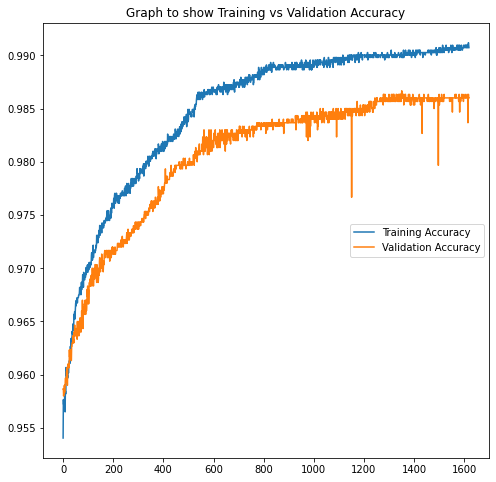

In [42]:
{x:len(bio[x]) for x in bio}

epochs_range = range(len(bio['accuracy']))
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, bio["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, bio["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Graph to show Training vs Validation Accuracy')

In [43]:
# histories = {}
# bio = {"accuracy":[], "val_accuracy": []}


# buckets = math.floor(EPOCHS/STEP_LENGTH)
# total_data = len(training)
# initial_data_count = math.floor(STARTING_PERCENT*total_data)
# curr_percentage = 1
# for i in range(0, buckets):
#     curr_percentage = (i+1)/buckets
#     # curr_percentage = min(curr_percentage*1.9, 1)
#     data_left = total_data-initial_data_count
#     offset_data_count = math.floor(curr_percentage*data_left)

#     upper_bound = initial_data_count + offset_data_count
#     data = training.loc[0: upper_bound]
#     history = model.fit(data[inputs], data[outputs], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=STEP_LENGTH, batch_size=BATCH_SIZE)

#     bio["accuracy"].extend(history.history['accuracy'])
#     bio["val_accuracy"].extend(history.history['val_accuracy'])

# {x:len(bio[x]) for x in bio}

# epochs_range = range(len(bio['accuracy']))
# plt.figure()
# plt.plot(epochs_range, bio["accuracy"], label='Training Accuracy')
# plt.plot(epochs_range, bio["val_accuracy"], label='Validation Accuracy')
# plt.legend(loc='center right')
# plt.title('Graph to show Training vs Validation Accuracy')

In [44]:
model.save(filepath="curriculum-neural-network.tf")

INFO:tensorflow:Assets written to: curriculum-neural-network.tf/assets


In [45]:
sample = evaluation.sample(5)
print(sample[outputs])
model.__call__(sample[inputs])

      class_GALAXY  class_QSO  class_STAR
8814           0.9        0.1         0.1
9187           0.1        0.1         0.9
9705           0.1        0.1         0.9
9666           0.9        0.1         0.1
9223           0.1        0.1         0.9


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.8924794 , 0.10513982, 0.10223702],
       [0.11484197, 0.09133551, 0.892205  ],
       [0.29506594, 0.09774345, 0.71995133],
       [0.89705765, 0.10200995, 0.10029092],
       [0.10089135, 0.10653818, 0.8936161 ]], dtype=float32)>